# Facial Expression Recognition in Real-time
Welcome to my Facial Expression Recognition project! In an age where non-verbal cues are as significant as the words we speak, understanding facial expressions becomes a crucial aspect of human-computer interaction. The primary goal of this project is to harness the power of machine learning and computer vision to recognize and classify human facial expressions in real-time.

## Overview:
Facial expressions are universal indicators of human emotions. Whether it's the evident joy in a smile or the subtle hints of surprise, our faces convey a multitude of emotions that transcend language barriers. In this project, we aim to delve deep into the world of computer vision to train a model that can accurately detect seven fundamental emotions: Happy, Sad, Angry, Surprised, Neutral, Disgusted, and Fearful.

### Key Features:
- __Data Exploration:__ Delve into the nuances of the _FER2013_ dataset, understanding its structure and the distribution of various facial expressions.
- __Model Development:__ Harness deep learning techniques by leveraging convolutional neural networks to optimize performance and generalize well on unseen data.
- __Real-time Analysis:__ Using OpenCV, capture video feed from a webcam or video and witness the model in action, identifying emotions on-the-fly.

### Potential Applications:
The implications of a robust facial expression recognition system are vast:

- __Enhanced User Experience:__ Imagine video games or applications adapting in real-time to users' emotions, offering a tailored, responsive experience.
- __Mental Health Monitoring:__ Regular monitoring and analysis of a person's facial expressions could offer insights into their mental well-being.
- __Human-computer Interaction:__ Make machines more empathetic, understanding, and interactive, paving the way for truly personalized computing experiences.

## 

### Dependencies and data

In [1]:
# Import necessary libraries
import kaggle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Reshape, UpSampling2D, Lambda
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import load_model

In this project I use the FER2013 dataset, a widely-used resource for facial expression recognition. The dataset is obtained from Kaggle using the Kaggle API, ensuring a straightforward and automated process for accessing these data.

In [2]:
# Download and unzip the FER2013 dataset
kaggle.api.authenticate()
dataset_name = "deadskull7/fer2013"
kaggle.api.dataset_download_files(dataset_name, path='./', unzip=True)

print("FER2013 dataset downloaded and extracted!")

FER2013 dataset downloaded and extracted!


While the FER2013 dataset is a valuable resource, it's worth noting that the AffectNet dataset is significantly larger and more diverse, potentially leading to better training results for advanced facial expression recognition models. However, unlike FER2013, AffectNet is not publicly available for direct download and requires obtaining access from the dataset creators. Researchers and developers seeking to enhance their models' performance with more extensive and varied data might consider requesting access to AffectNet. This additional step involves agreeing to specific terms and conditions but can provide a more robust dataset for training sophisticated facial expression recognition systems.

### 1. Load the dataset

In [3]:
# Load the dataset
data_path = "fer2013.csv"
df = pd.read_csv(data_path)
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


### 2. Examine the structure
The dataset has three columns:
- emotion: the emotion label.
- pixels: the pixel values for the images, space-separated.
- Usage: the purpose of this data (training, testing, validation).
Check the distribution of data across Usage:

In [4]:
print(df['Usage'].value_counts())

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64


### 3. Visualize some of the images

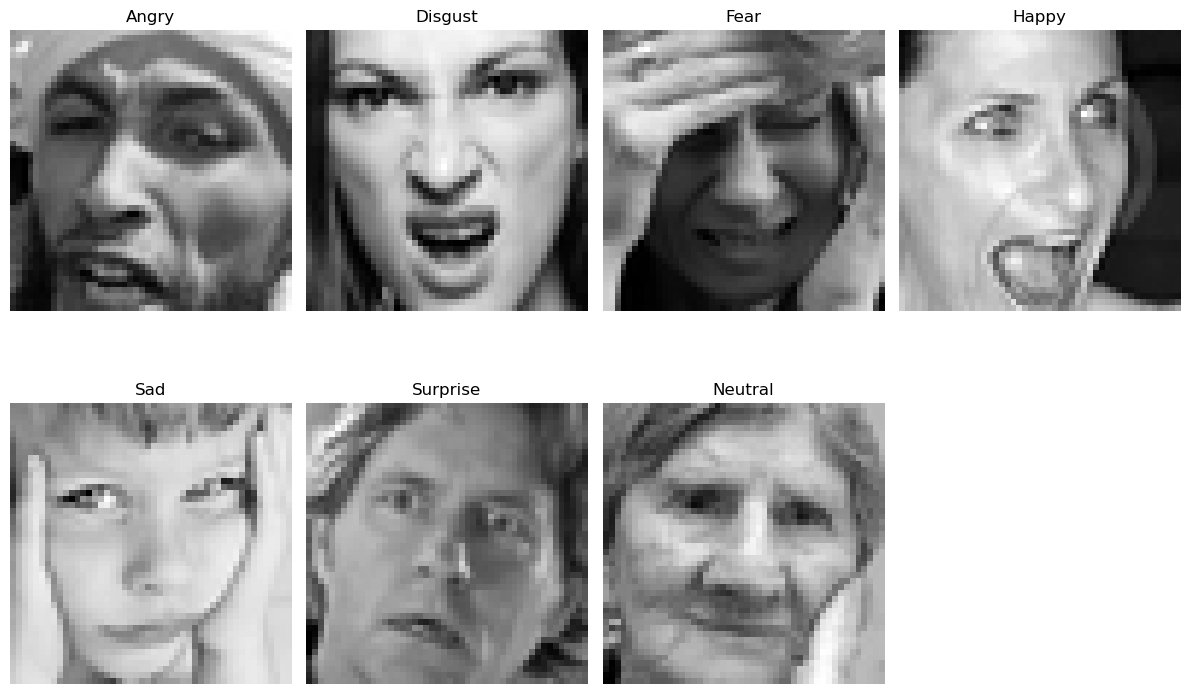

In [5]:
# Convert string pixels to numpy array
def string_to_image(pixel_string):
    pixels = np.array(pixel_string.split(' '), dtype=int)
    image = pixels.reshape(48, 48)
    return image

# Plot a random sample of images from each emotion
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

plt.figure(figsize=(12, 8))
for i in range(7):
    plt.subplot(2, 4, i+1)
    random_sample = df[df['emotion'] == i].sample(1).iloc[0]
    image = string_to_image(random_sample['pixels'])
    plt.imshow(image, cmap='gray')
    plt.title(emotion_labels[i])
    plt.axis('off')
    
plt.tight_layout()
plt.show()


### 4. Examine the distribution of facial expressions

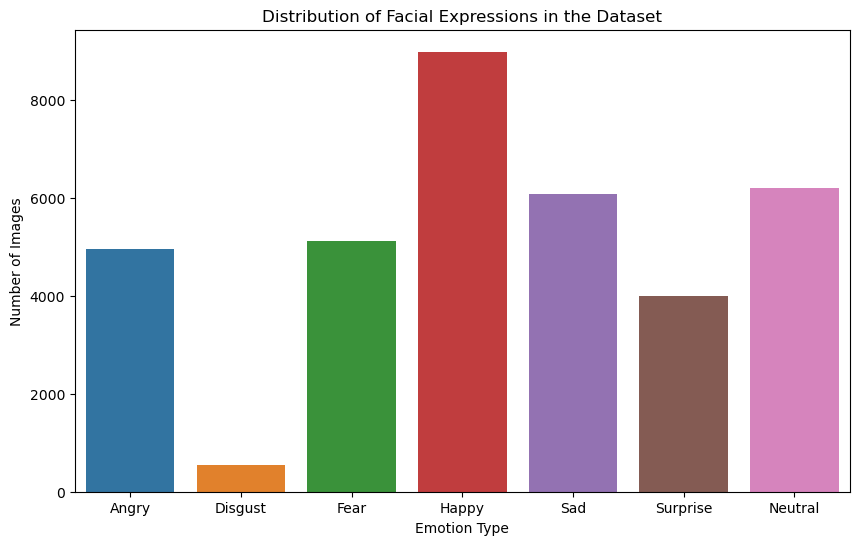

In [6]:
# Plot the distribution of the emotions
plt.figure(figsize=(10, 6))
sns.countplot(x='emotion', data=df)
plt.title('Distribution of Facial Expressions in the Dataset')
plt.ylabel('Number of Images')
plt.xlabel('Emotion Type')
plt.xticks(ticks=range(7), labels=emotion_labels)
plt.show()

## Datapreperations

### 1. Normalize the Images:
Neural networks tend to perform better when the input data is normalized. Given that these are grayscale images with pixel values ranging from 0 to 255, we can simply divide by 255 to scale the data to the range [0,1].

In [7]:
# Convert pixels to numpy arrays
df['pixels'] = df['pixels'].apply(lambda pixel_sequence: np.array(pixel_sequence.split(' '), dtype=float).reshape(48, 48) / 255.0)

### 2. Split the Dataset:
The FER2013 dataset provides predefined splits for training, validation, and testing. Let's utilize those:

In [8]:
# Splitting the dataset
train_df = df[df['Usage'] == 'Training']
val_df = df[df['Usage'] == 'PublicTest']
test_df = df[df['Usage'] == 'PrivateTest']

X_train = np.stack(train_df['pixels'].to_numpy())
X_val = np.stack(val_df['pixels'].to_numpy())
X_test = np.stack(test_df['pixels'].to_numpy())

# We need to add an extra dimension since CNNs expect batches of multi-channel images
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

y_train = train_df['emotion'].to_numpy()
y_val = val_df['emotion'].to_numpy()
y_test = test_df['emotion'].to_numpy()

print(f"Training samples: {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

Training samples: 28709
Validation samples: 3589
Testing samples: 3589


### 3. Data Augmentation

Using data augmentation can be a good approach if you think the model might overfit. Augmentation artificially increases the size of the training dataset by applying transformations like rotation, zoom, shift, etc. Here's a basic setup using ImageDataGenerator from Keras:

In [9]:
# Data Generator
data_generator = ImageDataGenerator(
    rotation_range=10,       # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,   # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    shear_range=0.1,         # apply shearing transformations
    zoom_range=0.1,          # randomly zoom into images
    horizontal_flip=True,    # randomly flip images horizontally
    fill_mode='nearest'      # fill in new pixels after a rotation or shift
)

# Fit the data generator
data_generator.fit(X_train)

## Model Building

### 1. Define the CNN Architecture
 Given the nature of the problem, a Convolutional Neural Network (CNN) is well-suited for this task. We can start with a relatively simple architecture and then fine-tune or expand as necessary.

In [10]:
model = Sequential([
    # First Convolutional Layer
    Conv2D(64, (5, 5), activation='elu', input_shape=(48, 48, 1), padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),

    # Second Convolutional Layer
    Conv2D(64, (5, 5), activation='elu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.3),

    # Third Convolutional Layer
    Conv2D(128, (3, 3), activation='elu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),

    # Fourth Convolutional Layer
    Conv2D(128, (3, 3), activation='elu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.3),
    
    # Fifth Convolutional Layer
    Conv2D(256, (3, 3), activation='elu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),

    # Sixth Convolutional Layer
    Conv2D(256, (3, 3), activation='elu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.35),

    # Flatten the results to feed into a dense layer
    Flatten(),
    
    # 256 neuron in the fully-connected layer
    Dense(256, activation='elu'),
    BatchNormalization(),
    Dropout(0.35),

    # 7 output neurons for 7 classes with the softmax activation
    Dense(7, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        1664      
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batch_normalization_1 (Bat  (None, 48, 48, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                        

In [12]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, LayerNormalization, MultiHeadAttention
from tensorflow.keras.models import Model
import tensorflow as tf

# Define the input shape
input_shape = (48, 48, 1)

# Create a new input layer
inputs = tf.keras.Input(shape=input_shape)

# Convert grayscale to RGB
x = Lambda(lambda x: tf.repeat(x, 3, -1))(inputs)

# Load pre-trained MobileNetV2 model without the top layer
# Note: We use the modified input 'x' here
base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=x)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top for facial expression classification
x = base_model.output

# Convolutional and pooling layers
x = Conv2D(64, (5, 5), activation='elu', padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (5, 5), activation='elu', padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)
x = Dropout(0.3)(x)

x = Conv2D(128, (3, 3), activation='elu', padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='elu', padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)
x = Dropout(0.3)(x)

x = Conv2D(256, (3, 3), activation='elu', padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Conv2D(256, (3, 3), activation='elu', padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)
x = Dropout(0.35)(x)

# Flatten and fully connected layers
x = Flatten()(x)
x = Dense(256, activation='elu')(x)
x = BatchNormalization()(x)
x = Dropout(0.35)(x)

# Final classification layer
predictions = Dense(7, activation='softmax')(x)



# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 48, 48, 1)]          0         []                            
                                                                                                  
 lambda_1 (Lambda)           (None, 48, 48, 3)            0         ['input_2[0][0]']             
                                                                                                  
 Conv1 (Conv2D)              (None, 24, 24, 32)           864       ['lambda_1[0][0]']            
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 24, 24, 32)           128       ['Conv1[0][0]']               
 on)                                                                                          

This model uses a combination of convolutional layers followed by max-pooling. Dropout layers are added to prevent overfitting, and BatchNormalization helps in accelerating the training process.

### 2. Compile the model
To prepare the model for training, we need to compile it by specifying a loss function, an optimizer, and a metric to monitor during training.

In [ ]:
#model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### 3. Train the Model
Now, we'll train the model. To enhance the model's ability to generalize and potentially improve its accuracy, we're utilizing data augmentation through the ImageDataGenerator we defined earlier.

During the training process, you'll observe the training and validation accuracy/loss for each epoch. To optimize our model's performance and ensure efficient training, we have incorporated both early stopping and learning rate reduction based on plateaus.

__Early Stopping:__ This is a regularization technique used during the training of a model to prevent overfitting. It monitors a specified metric (in our case, the validation loss) and halts the training process if this metric does not show improvement for a specified number of consecutive epochs. It ensures that we do not waste computational resources and time by continuing to train a model that has ceased to improve.

__ReduceLROnPlateau:__ To ensure the model converges efficiently, we've also introduced a learning rate reduction strategy. If the model's validation performance doesn't improve for a set number of epochs, the learning rate is reduced by a factor, allowing for potentially finer adjustments in the model weights. This can help the model escape local minima in the loss landscape and lead to a more optimal solution.

With these callbacks in place, the training might stop before reaching the maximum number of epochs if the model's performance on the validation set doesn't improve for the duration specified by their respective patience parameters.

In [ ]:
# Training parameters
epochs = 100
batch_size = 128

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',          # Quantity to be monitored
    patience=10,                 # Number of epochs with no improvement after which training will be stopped
    verbose=1,                   # Verbosity mode (0 = silent, 1 = progress bar)
    restore_best_weights=True    # Whether to restore model weights from the epoch with the best value of the monitored quantity
)

# Define ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,       # Factor by which the learning rate will be reduced
    patience=5,       # Number of epochs with no improvement to wait before reducing the learning rate
    verbose=1,
    min_delta=0.0001, # Threshold for measuring the new optimum
    cooldown=2,       # Number of epochs to wait before resuming normal operation after lr has been reduced.
    min_lr=0.00001    # Lower bound on the learning rate
)

# List of callbacks
callbacks = [early_stopping, reduce_lr]

# Load previous trained model if it exists
# model = load_model('facial_expression_recognition_model')

# Train the model
history = model.fit(data_generator.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_val, y_val),
                    steps_per_epoch=len(X_train) // batch_size,
                    epochs=epochs,
                    callbacks=callbacks)

Epoch 1/100
224/224 [==============================] - 38s 156ms/step - loss: 1.7711 - accuracy: 0.3088 - val_loss: 1.6102 - val_accuracy: 0.3628 - lr: 0.0010
Epoch 2/100
224/224 [==============================] - 35s 156ms/step - loss: 1.6515 - accuracy: 0.3462 - val_loss: 1.5897 - val_accuracy: 0.3781 - lr: 0.0010
Epoch 3/100
224/224 [==============================] - 34s 152ms/step - loss: 1.6302 - accuracy: 0.3549 - val_loss: 1.5820 - val_accuracy: 0.3773 - lr: 0.0010
Epoch 4/100
224/224 [==============================] - 34s 154ms/step - loss: 1.6129 - accuracy: 0.3642 - val_loss: 1.5785 - val_accuracy: 0.3820 - lr: 0.0010
Epoch 5/100
224/224 [==============================] - 34s 154ms/step - loss: 1.6039 - accuracy: 0.3686 - val_loss: 1.5662 - val_accuracy: 0.3817 - lr: 0.0010
Epoch 6/100
224/224 [==============================] - 34s 152ms/step - loss: 1.5946 - accuracy: 0.3730 - val_loss: 1.5698 - val_accuracy: 0.3837 - lr: 0.0010
Epoch 7/100
224/224 [=========================

After training, it's advisable to visualize the training history to check for overfitting and determine if further tuning is necessary.

It's worth noting that I've iteratively adjusted and refined the model architecture throughout our experimentation process to find the best-performing one. Despite these modifications, depending on the performance, there might still be room for improvement. You might need to further tweak the architecture, introduce additional regularization methods, or fine-tune hyperparameters.

Remember, the process of building a neural network is often iterative, and the journey to the optimal model may require several rounds of tuning and validation.

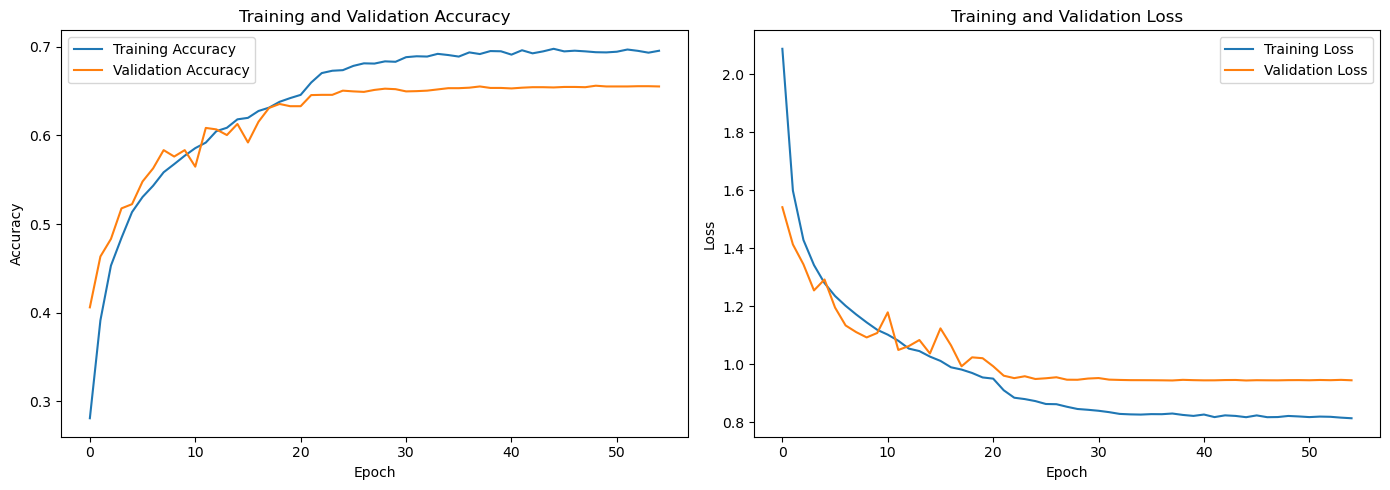

In [ ]:
# Plotting Training and Validation Accuracy
plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Save the model
model.save('facial_expression_recognition_model')

INFO:tensorflow:Assets written to: facial_expression_recognition_model\assets


INFO:tensorflow:Assets written to: facial_expression_recognition_model\assets


### 4. Hyperparameter Tuning and Model Evaluation

Upon training our facial expression recognition model, we achieved a training accuracy of approximately 72.66% and a validation accuracy of 66.40%. Training was terminated at Epoch 52 due to the early stopping criteria being met, which indicates that there was no substantial improvement in the validation loss for the specified patience duration.

#### Observations

Training and Validation Accuracy: The model shows a decent training accuracy. However, there is a gap between the training and validation accuracy, which suggests that the model might be overfitting to the training data to a certain extent.

Loss Values: A similar pattern is observed in the loss values. The training loss is relatively lower than the validation loss, further highlighting the potential overfitting.

Early Stopping: The utilization of early stopping ensured that we did not continue to train the model unnecessarily once it stopped showing significant improvement. This not only saves computational resources but also helps in preventing potential overfitting. The fact that training was halted at Epoch 52 suggests that further training epochs might not have led to substantial benefits in this scenario.

For a conceptual project, the results achieved are promising. There's always room for improvement, and typically in a more extensive project, further strategies like deeper architectures, more advanced regularization techniques, or even ensemble methods might be explored. Hyperparameter tuning can be a meticulous process, often requiring multiple iterations and experiments to find the optimal set of parameters.

Given the project's conceptual nature, we won't be delving deeper into hyperparameter tuning or other optimization strategies. The model serves as a good starting point, demonstrating the potential of CNNs in facial expression recognition tasks. Future endeavors can build upon this foundation, introducing more sophisticated techniques and fine-tuning to achieve superior performance.

## Real-Time Emotion Recognition from Video
In this section, I implement of a real-time emotion recognition system that processes video input. It detects face and uses the model we've created above to identify and label human emotions on each detected face.

### Overview of the Process
The process involves several key steps:

1. __Video Processing:__ The system reads frames from a video file. This approach can be adapted for live video streams, including webcam feeds.

2. __Face Detection:__ Each frame is analyzed to detect human faces. We use OpenCV's Haar cascades, a popular method for object detection, to identify faces in each frame.

3. __Emotion Recognition:__ Upon detecting a face, the region of interest is resized to a standard dimension (48x48 pixels in grayscale) to match the input requirements of our pre-trained emotion recognition model.

4. __Displaying Results:__ For each detected face, the system predicts the emotion and displays it as a label on the video frame. This real-time annotation includes drawing bounding boxes around faces and overlaying text labels indicating the identified emotions.

In [ ]:
# Load the model
model = load_model('facial_expression_recognition_model')

In [ ]:
# Load Haar cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def process_frame(frame):
    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)

    for (x, y, w, h) in faces:
        # Crop and resize face
        face = gray[y:y+h, x:x+w]
        resized_face = cv2.resize(face, (48, 48), interpolation=cv2.INTER_AREA)

        # Convert to PIL Image for more processing if needed
        pil_image = Image.fromarray(resized_face)
        bw_image = pil_image.convert('L')

        # Convert PIL Image to numpy array
        img_array = np.array(bw_image)

        # Reshape it to the required input shape of the model (e.g., (1, 48, 48, 1))
        img_array = img_array.reshape(1, 48, 48, 1)

        # Normalize the image if your model expects pixel values to be in a certain range
        img_array = img_array / 255.0

        # Predict the emotion
        emotion_prediction = model.predict(img_array)
        
        # Map the index of the highest probability to the corresponding emotion label
        emotion_label = emotion_labels[np.argmax(emotion_prediction)]

        # Draw rectangle around the face
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 255), 2)

        # Put text (emotion label) above the rectangle
        cv2.putText(frame, emotion_label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 255), 2)

    return frame


### Video as Testcase
I have compiled a video of different emotions from YouTube. You can use your own video by changing the video path on the second line bellow. 

In [ ]:
# Open the video file
video_path = 'emotions.mp4'  # Replace with your video file path
cap = cv2.VideoCapture(video_path)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Process frame
    processed_frame = process_frame(frame)

    # Display the resulting frame
    cv2.imshow('Video', processed_frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 23ms/step
